# Prepare data

It's the Newsgroup20 data sentiment-prediction task.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

Download the Newsgroup20 data

In [2]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

17334272/17329808 [==============================] - 12s 1us/step


In [3]:
import os
import pathlib

data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])


Number of directories: 20
Directory names: ['comp.sys.ibm.pc.hardware', 'sci.electronics', 'comp.sys.mac.hardware', 'rec.sport.hockey', 'talk.politics.guns', 'sci.crypt', 'talk.politics.misc', 'comp.graphics', 'alt.atheism', 'comp.windows.x', 'talk.religion.misc', 'comp.os.ms-windows.misc', 'soc.religion.christian', 'rec.sport.baseball', 'sci.space', 'misc.forsale', 'rec.motorcycles', 'talk.politics.mideast', 'sci.med', 'rec.autos']
Number of files in comp.graphics: 1000
Some example filenames: ['39073', '38803', '37936', '38853', '38353']


Get rid of the headers

In [4]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("length classes:", len(class_names))
print("Number of samples:", len(samples))
print('sample len:  ',len(samples[455]))
print(samples[455])



Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.os.ms-windows.misc, 1000 files found
Processing comp.sys.ibm.pc.hardware, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.motorcycles, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.electronics, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.mideast, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.ha

Shuffle and split the data into training & validation sets

In [5]:
# Shuffle the data
seed = 1400
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
samples = samples[:15000]
labels = labels[:15000]
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

print("Number of train samples:", len(train_labels))
print("Number of validation samples:", len(val_labels))

Number of train samples: 12000
Number of validation samples: 3000


Create a vocabulary index

In [6]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'to', 'of', 'a', 'and', 'in', 'is', 'i']

 Dict mapping words to their indices

In [7]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

test = ["i", "study", "in", "iran", "university"]
[word_index[w] for w in test]



[9, 759, 7, 2125, 169]

In [8]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)
print(x_train.shape)


(12000, 200)


Plot history fuction

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [10]:
from keras.models import Sequential
from keras import layers
from keras.datasets import imdb
from keras import preprocessing

num_tokens = len(voc) + 2
embedding_dim = 100
print("Number of tokens:", num_tokens)

Number of tokens: 20002


# Evaluate without Embedding

## Integer codes

In [11]:
x_train_expand = np.expand_dims(x_train, axis=2)
x_val_expand = np.expand_dims(x_val, axis=2)

print(x_train_expand.shape)
print(x_train.shape)
print(x_train_expand[1][10])

print(y_val.shape)
print(x_val_expand.shape)

#Implement your model
model = Sequential()

model.add(keras.layers.GRU(100, input_shape=((x_train_expand.shape[1:]))))
model.add(keras.layers.Dense(20, activation='softmax'))

model.summary()

(12000, 200, 1)
(12000, 200)
[2118]
(3000,)
(3000, 200, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               30900     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 32,920
Trainable params: 32,920
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
188/188 [==============================] - 39s 46ms/step - loss: 3.0087 - accuracy: 0.0676 - val_loss: 2.9674 - val_accuracy: 0.0663
Epoch 2/100
188/188 [==============================] - 8s 40ms/step - loss: 2.9606 - accuracy: 0.0733 - val_loss: 2.9521 - val_accuracy: 0.0707
Epoch 3/100
188/188 [==============================] - 7s 40ms/step - loss: 2.9523 - accuracy: 0.0770 - val_loss: 2.9480 - val_accuracy: 0.0780
Epoch 4/100
188/188 [==============================] - 7s 40ms/step - loss: 2.9482 - accuracy: 0.0733 - val_loss: 2.9422 - val_accuracy: 0.0763
Epoch 5/100
188/188 [==============================] - 7s 39ms/step - loss: 2.9375 - accuracy: 0.0863 - val_loss: 2.9387 - val_accuracy: 0.0767
Epoch 6/100
188/188 [==============================] - 7s 39ms/step - loss: 2.9284 - accuracy: 0.0806 - val_loss: 2.9341 - val_accuracy: 0.0820
Epoch 7/100
188/188 [==============================] - 7s 40ms/step - loss: 2.9237 - accuracy: 0.0845 - val_loss: 2.9305 - val_accuracy

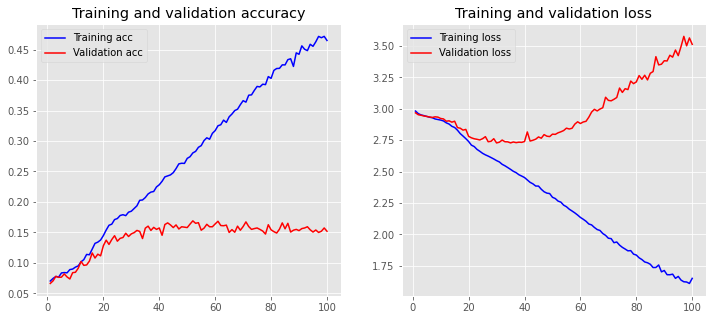

In [12]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model (training and validation)
history = model.fit(x_train_expand, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_val_expand, y_val))

# Plot history
plot_history(history)

## One-hot

In [18]:
from keras import backend as K

#Implement your model
model = Sequential()
model.add(layers.Input(shape=x_train.shape[1:], dtype='int32'))
model.add(layers.Lambda(K.one_hot, arguments={'num_classes': num_tokens}))
# Complete the model here!


model.add(keras.layers.GRU(30, input_shape=((x_train_expand.shape[1:]))))
model.add(keras.layers.Dense(20, activation='softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 200, 20002)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                1803060   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
Total params: 1,803,680
Trainable params: 1,803,680
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
188/188 [==============================] - 74s 233ms/step - loss: 2.9864 - accuracy: 0.0569 - val_loss: 2.8800 - val_accuracy: 0.0797
Epoch 2/100
188/188 [==============================] - 43s 231ms/step - loss: 2.9141 - accuracy: 0.0764 - val_loss: 2.7646 - val_accuracy: 0.0943
Epoch 3/100
188/188 [==============================] - 43s 231ms/step - loss: 2.9001 - accuracy: 0.0944 - val_loss: 2.9852 - val_accuracy: 0.0643
Epoch 4/100
188/188 [==============================] - 43s 231ms/step - loss: 2.9576 - accuracy: 0.1526 - val_loss: 2.8499 - val_accuracy: 0.1023
Epoch 5/100
188/188 [==============================] - 43s 231ms/step - loss: 2.7532 - accuracy: 0.1685 - val_loss: 2.9593 - val_accuracy: 0.0717
Epoch 6/100
188/188 [==============================] - 43s 231ms/step - loss: 2.8611 - accuracy: 0.1874 - val_loss: 2.7542 - val_accuracy: 0.1023
Epoch 7/100
188/188 [==============================] - 43s 231ms/step - loss: 2.6763 - accuracy: 0.1972 - val_loss: 2.8402 -

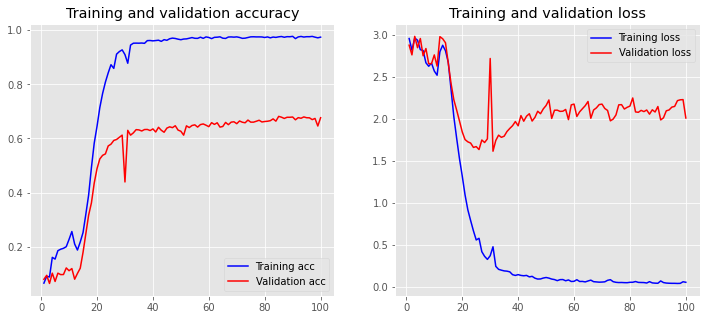

In [19]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model (training and validation)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_val, y_val))

# Plot history
plot_history(history)

# Evaluate with Embedding

##Use embedding trainable = False

In [12]:
#Implement your model
#trainable=False
from tensorflow.keras import initializers

model = keras.Sequential()
model.add(keras.layers.Embedding(20000, 20, input_length=200, trainable=False, embeddings_initializer=initializers.RandomNormal(stddev=0.1)))
model.add(keras.layers.GRU(30, input_shape=((x_val.shape[1:]))))
model.add(keras.layers.Dense(20, activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 20)           400000    
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                4680      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
Total params: 405,300
Trainable params: 5,300
Non-trainable params: 400,000
_________________________________________________________________


Epoch 1/100
188/188 [==============================] - 18s 86ms/step - loss: 2.9930 - accuracy: 0.0521 - val_loss: 2.9656 - val_accuracy: 0.0747
Epoch 2/100
188/188 [==============================] - 15s 81ms/step - loss: 2.9666 - accuracy: 0.0721 - val_loss: 2.9558 - val_accuracy: 0.0740
Epoch 3/100
188/188 [==============================] - 15s 81ms/step - loss: 2.9602 - accuracy: 0.0729 - val_loss: 2.9372 - val_accuracy: 0.0803
Epoch 4/100
188/188 [==============================] - 15s 82ms/step - loss: 2.9396 - accuracy: 0.0798 - val_loss: 2.9055 - val_accuracy: 0.0853
Epoch 5/100
188/188 [==============================] - 15s 82ms/step - loss: 2.9095 - accuracy: 0.0793 - val_loss: 2.8850 - val_accuracy: 0.0857
Epoch 6/100
188/188 [==============================] - 15s 82ms/step - loss: 2.8840 - accuracy: 0.0859 - val_loss: 2.8711 - val_accuracy: 0.0837
Epoch 7/100
188/188 [==============================] - 15s 81ms/step - loss: 2.8555 - accuracy: 0.0874 - val_loss: 2.8524 - val_ac

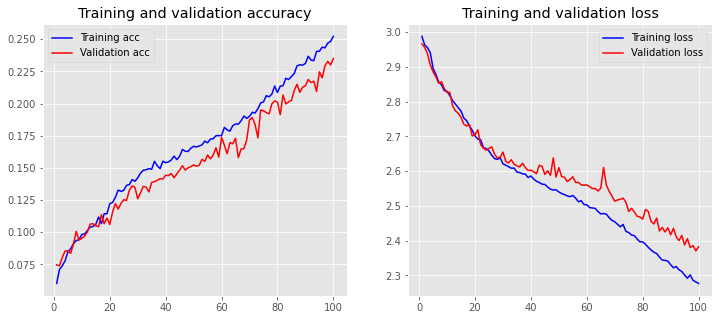

In [13]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model (training and validation)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_val, y_val))

# Plot history
plot_history(history)

## embedding trainable = True

In [14]:
#Implement your model

from tensorflow.keras import initializers

model = keras.Sequential()
model.add(keras.layers.Embedding(20000, 20, input_length=200))
model.add(keras.layers.GRU(30, input_shape=((x_val.shape[1:]))))
model.add(keras.layers.Dense(20, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 20)           400000    
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                4680      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
Total params: 405,300
Trainable params: 405,300
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
188/188 [==============================] - 20s 96ms/step - loss: 2.9846 - accuracy: 0.0638 - val_loss: 2.8755 - val_accuracy: 0.0790
Epoch 2/100
188/188 [==============================] - 18s 94ms/step - loss: 2.7851 - accuracy: 0.0950 - val_loss: 2.6904 - val_accuracy: 0.0897
Epoch 3/100
188/188 [==============================] - 18s 94ms/step - loss: 2.8702 - accuracy: 0.0899 - val_loss: 2.9848 - val_accuracy: 0.0613
Epoch 4/100
188/188 [==============================] - 18s 94ms/step - loss: 2.9711 - accuracy: 0.0744 - val_loss: 2.9574 - val_accuracy: 0.0730
Epoch 5/100
188/188 [==============================] - 18s 94ms/step - loss: 2.9464 - accuracy: 0.0816 - val_loss: 2.9441 - val_accuracy: 0.0753
Epoch 6/100
188/188 [==============================] - 18s 96ms/step - loss: 2.9244 - accuracy: 0.0895 - val_loss: 2.9129 - val_accuracy: 0.0870
Epoch 7/100
188/188 [==============================] - 19s 101ms/step - loss: 2.8798 - accuracy: 0.1110 - val_loss: 2.7387 - val_a

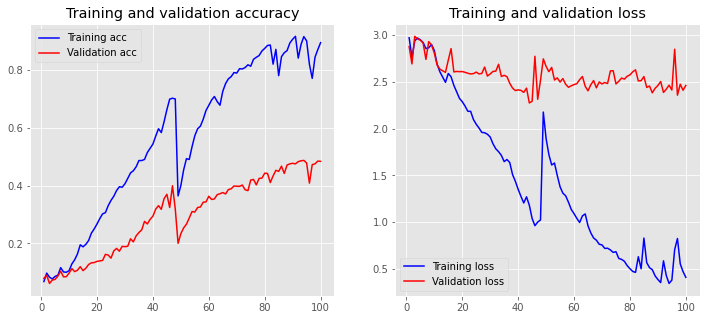

In [15]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model (training and validation)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_val, y_val))

# Plot history
plot_history(history)

# Evaluate with pretrained Embedding

In [16]:
!gdown http://nlp.stanford.edu/data/glove.6B.zip

Downloading...
From: http://nlp.stanford.edu/data/glove.6B.zip
To: /content/glove.6B.zip
100% 862M/862M [02:40<00:00, 5.38MB/s]


In [17]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
import numpy as np

embeddings_index = {}

f = open("glove.6B.100d.txt", encoding='utf-8') #added , encoding='utf-8'
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("found %s word vectors." % len(embeddings_index))

found 400000 word vectors.


In [19]:
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17912 words (2088 misses)


## Use embedding_matrix as weights and embedding trainable = False

In [25]:
#Implement your model
print(embedding_matrix.shape)
model = keras.Sequential()
model.add(keras.layers.Embedding(20002, 100, input_length=200, trainable=False, weights=[embedding_matrix]))
model.add(keras.layers.GRU(30, input_shape=((x_val.shape[1:]))))
model.add(keras.layers.Dense(20, activation='softmax'))

model.summary()

(20002, 100)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          2000200   
_________________________________________________________________
gru_3 (GRU)                  (None, 30)                11880     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
Total params: 2,012,700
Trainable params: 12,500
Non-trainable params: 2,000,200
_________________________________________________________________


Epoch 1/100
188/188 [==============================] - 20s 98ms/step - loss: 2.9873 - accuracy: 0.0638 - val_loss: 2.8849 - val_accuracy: 0.0930
Epoch 2/100
188/188 [==============================] - 18s 95ms/step - loss: 2.7663 - accuracy: 0.1209 - val_loss: 2.5486 - val_accuracy: 0.1517
Epoch 3/100
188/188 [==============================] - 18s 95ms/step - loss: 2.4944 - accuracy: 0.1681 - val_loss: 2.3609 - val_accuracy: 0.1940
Epoch 4/100
188/188 [==============================] - 18s 96ms/step - loss: 2.3509 - accuracy: 0.2208 - val_loss: 2.2625 - val_accuracy: 0.2470
Epoch 5/100
188/188 [==============================] - 18s 97ms/step - loss: 2.2159 - accuracy: 0.2546 - val_loss: 2.2637 - val_accuracy: 0.2563
Epoch 6/100
188/188 [==============================] - 18s 96ms/step - loss: 2.2119 - accuracy: 0.2758 - val_loss: 2.0894 - val_accuracy: 0.2993
Epoch 7/100
188/188 [==============================] - 18s 96ms/step - loss: 2.0421 - accuracy: 0.3153 - val_loss: 2.0099 - val_ac

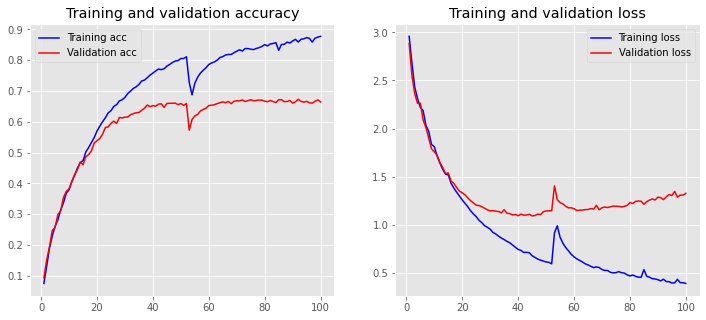

In [26]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model (training and validation)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_val, y_val))

# Plot history
plot_history(history)

## Use embedding_matrix as weights and embedding trainable = True

In [27]:
#Implement your model
print(embedding_matrix.shape)
model = keras.Sequential()
model.add(keras.layers.Embedding(20002, 100, input_length=200, weights=[embedding_matrix]))
model.add(keras.layers.GRU(30, input_shape=((x_val.shape[1:]))))
model.add(keras.layers.Dense(20, activation='softmax'))

model.summary()

(20002, 100)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          2000200   
_________________________________________________________________
gru_4 (GRU)                  (None, 30)                11880     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
Total params: 2,012,700
Trainable params: 2,012,700
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model (training and validation)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_val, y_val))

# Plot history
plot_history(history)

Epoch 1/100
188/188 [==============================] - 29s 142ms/step - loss: 2.9734 - accuracy: 0.0667 - val_loss: 2.8919 - val_accuracy: 0.0903
Epoch 2/100
188/188 [==============================] - 26s 138ms/step - loss: 2.8795 - accuracy: 0.1107 - val_loss: 2.8710 - val_accuracy: 0.1120
Epoch 3/100
188/188 [==============================] - 26s 139ms/step - loss: 2.8174 - accuracy: 0.1460 - val_loss: 2.7326 - val_accuracy: 0.1453
Epoch 4/100
188/188 [==============================] - 26s 138ms/step - loss: 2.5666 - accuracy: 0.1996 - val_loss: 2.3830 - val_accuracy: 0.2073
Epoch 5/100
188/188 [==============================] - 26s 137ms/step - loss: 2.1999 - accuracy: 0.3037 - val_loss: 1.9933 - val_accuracy: 0.3383
Epoch 6/100
188/188 [==============================] - 26s 137ms/step - loss: 1.8053 - accuracy: 0.4135 - val_loss: 1.7752 - val_accuracy: 0.3927
Epoch 7/100
188/188 [==============================] - 26s 138ms/step - loss: 1.6036 - accuracy: 0.4821 - val_loss: 1.6686 -